# Project Name: Exploratory Text Analysis & Topic Discovery Using LDA and Statistical NLP

## Overview
A digital media company wants to automatically categorize and understand the thematic content of large document collections from various sources (news articles, forum discussions, research papers, etc.). Manual content analysis is time-consuming and inconsistent across different analysts.

You have:
● **Text corpus data**: Raw documents with varying lengths, writing styles, and subject matters
● **Document metadata**: Categories, timestamps, source information, document length statistics
● **Preprocessing requirements**: Noise removal, tokenization, stopword filtering, and lemmatization needs

We will:
1. **Preprocess text data** using advanced NLP techniques including tokenization, stopword removal, and lemmatization
2. **Apply dimensionality reduction** through document-term matrix creation and feature selection to handle high-dimensional text data
3. **Implement Latent Dirichlet Allocation (LDA)** to discover hidden topic structures and probabilistic topic assignments
4. **Perform statistical analysis** to evaluate topic quality, document-topic distributions, and model performance using perplexity scores
5. **Visualize topic relationships** through word clouds, topic similarity matrices, and document clustering

## Goal
Content teams can use these insights for automated content categorization, improved search functionality, personalized content recommendations, and data-driven editorial decision making. The system enables scalable analysis of thousands of documents while maintaining interpretable results for business stakeholders.


In [2]:
# Standard data manipulation and visualization libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Natural Language Processing libraries
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Scikit-learn for topic modeling and text processing
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

import base64
from IPython.display import display, HTML
import os

# Additional utilities
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

#### Notebook utility

In [21]:
image_paths = ["lda1.png", "lda2.webp", "lda3.webp","lda4.webp","textvect1.webp","textvect2.webp","textvect3.webp"]
image_size = [500, 600, 600, 600, 600, 600, 600, 600]
images_html = []

mime_map = {
    ".png": "image/png",
    ".jpg": "image/jpeg",
    ".jpeg": "image/jpeg",
    ".gif": "image/gif",
    ".webp": "image/webp"
}

for i, path in enumerate(image_paths):
    ext = os.path.splitext(path)[1].lower()
    mime = mime_map.get(ext, "image/png")

    with open("../img/"+path, "rb") as f:
        data = f.read()
    encoded = base64.b64encode(data).decode("utf-8")

    img_tag = f'<img src="data:{mime};base64,{encoded}" style="display: block; margin-left: auto; margin-right: auto; width: {image_size[i]}px;" /><br>'
    images_html.append(img_tag)


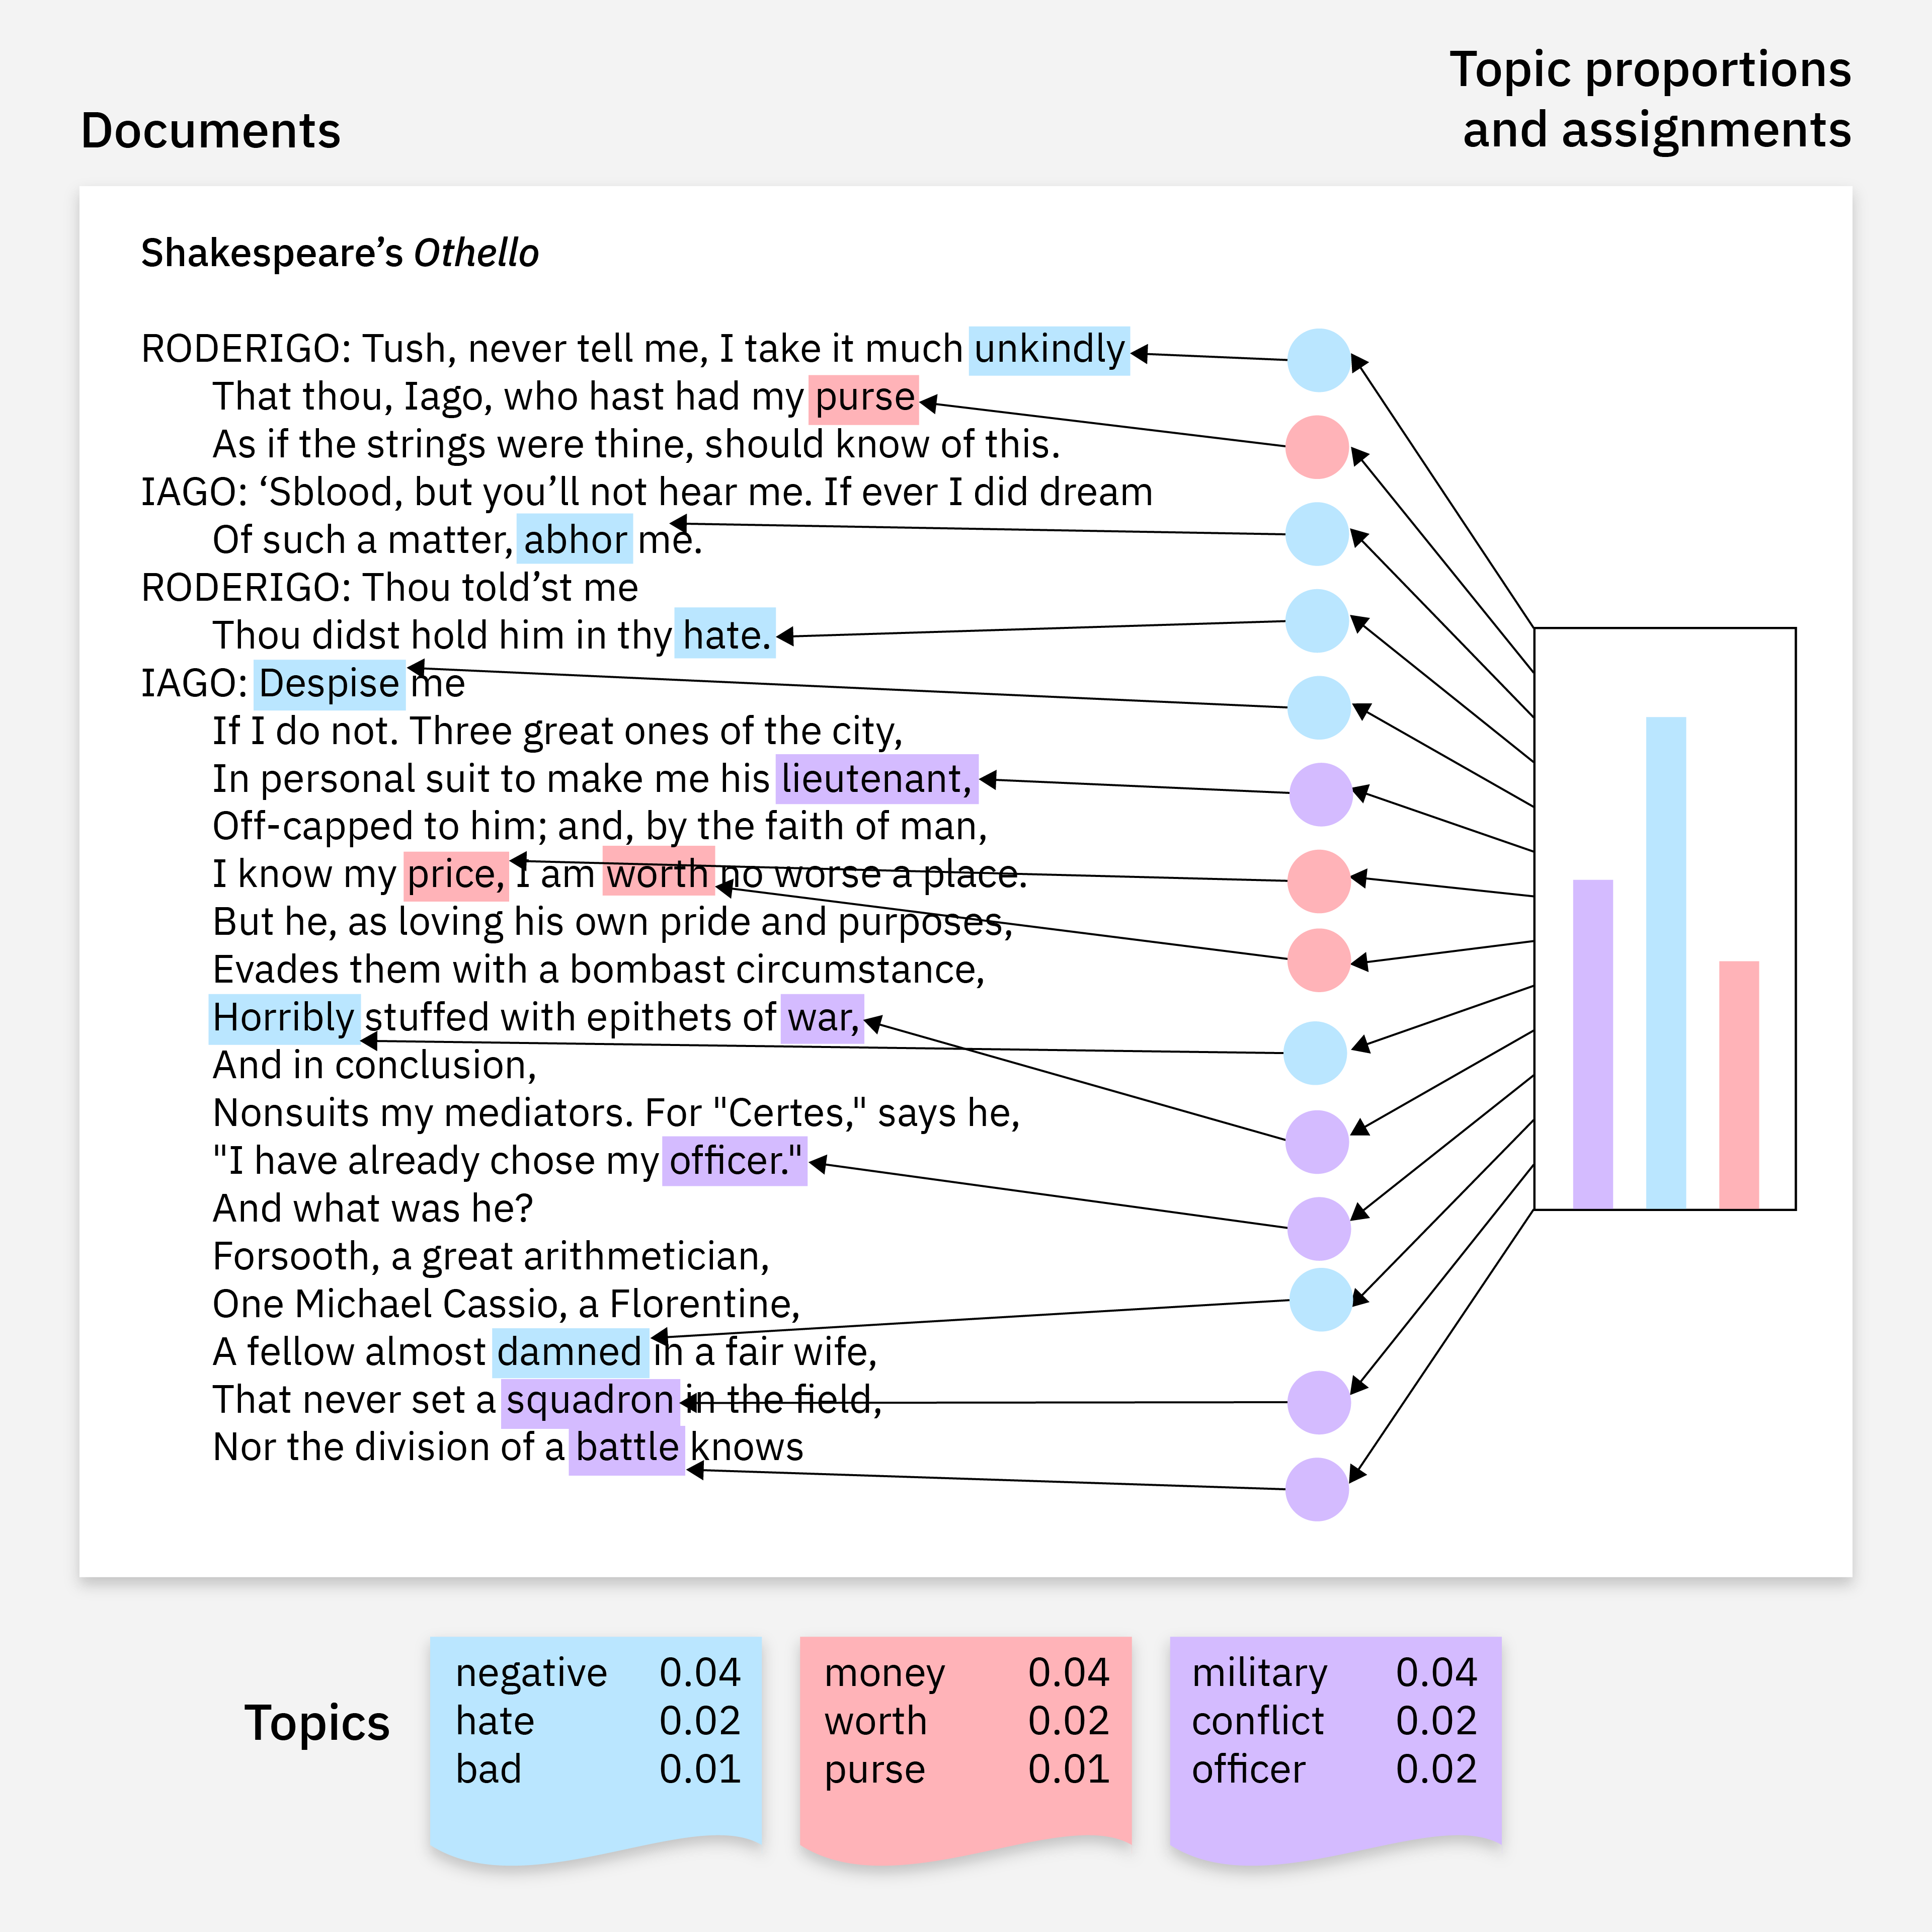

In [22]:
display(HTML(images_html[0]))


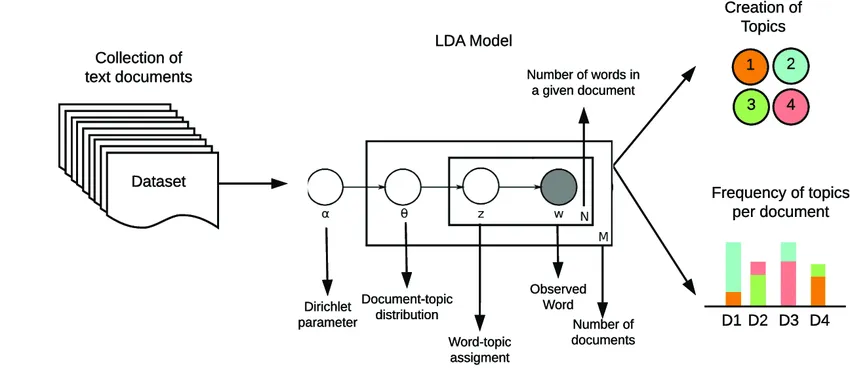

In [23]:
display(HTML(images_html[1]))


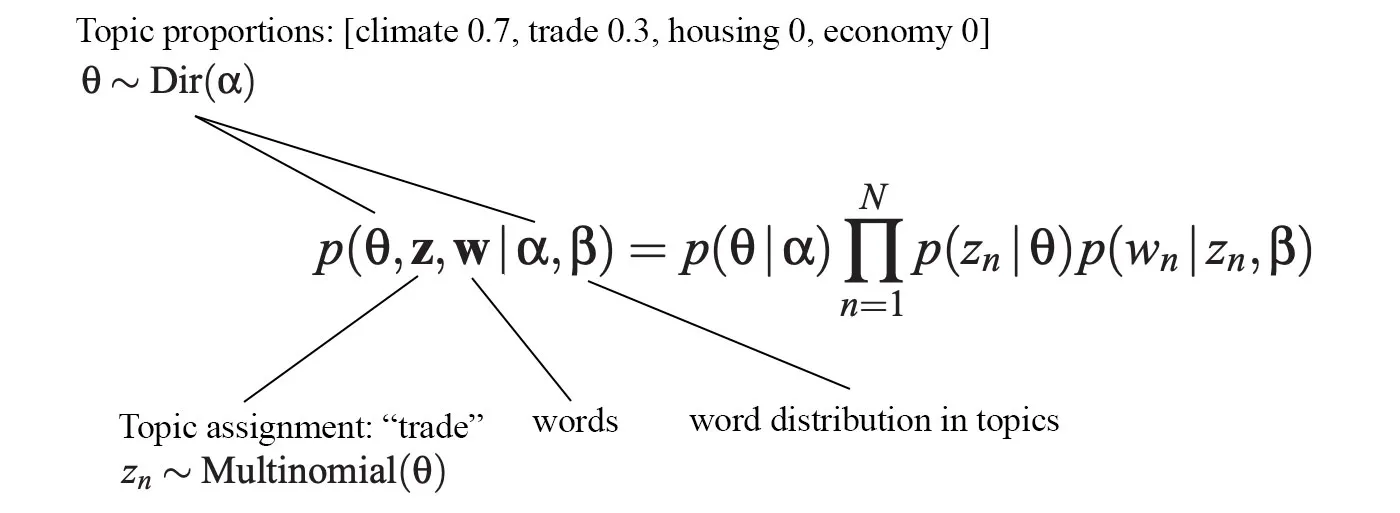

In [24]:
display(HTML(images_html[2]))


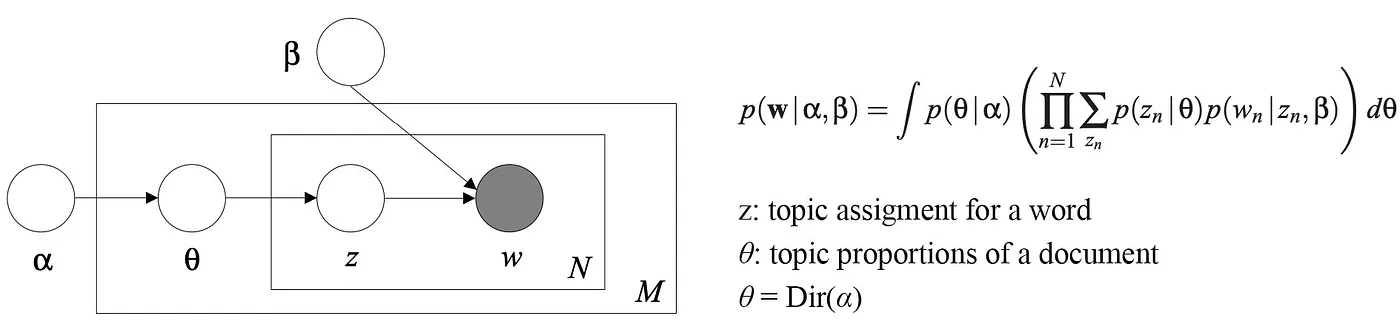

In [25]:
display(HTML(images_html[3]))


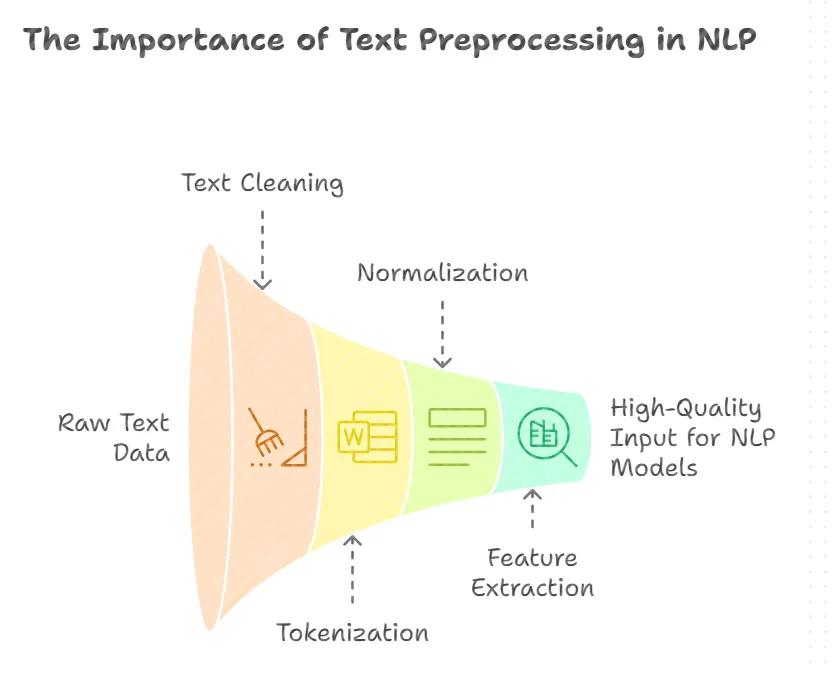

In [27]:
display(HTML(images_html[5]))


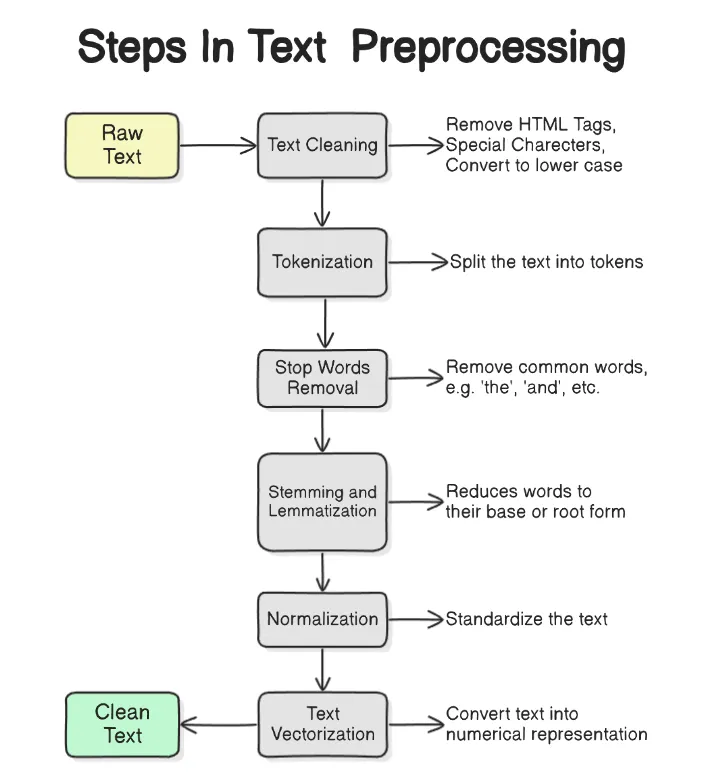

In [28]:
display(HTML(images_html[6]))

#### Load the 20 Newsgroups dataset
- This dataset contains approximately 20,000 newsgroup documents across 20 categories
- We'll use a subset for faster processing while maintaining diversity

In [5]:
# Fetch training data from specific categories to ensure topic diversity
categories = ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc',
              'comp.sys.ibm.pc.hardware', 'rec.autos', 'rec.motorcycles',
              'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt',
              'sci.electronics', 'sci.med', 'sci.space']

# Load dataset with headers and footers removed for cleaner text
newsgroups_data = fetch_20newsgroups(subset='train', 
                                   categories=categories,
                                   remove=('headers', 'footers', 'quotes'))

# Convert to DataFrame for easier manipulation
df = pd.DataFrame({
    'text': newsgroups_data.data,
    'category': [newsgroups_data.target_names[i] for i in newsgroups_data.target]
})

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
print(f"Categories: {df['category'].unique()}")
print(f"\nFirst document preview:")
print(df['text'].iloc[0][:500] + "...")


Dataset shape: (7007, 2)
Categories: ['rec.sport.hockey' 'comp.sys.ibm.pc.hardware' 'rec.autos'
 'rec.motorcycles' 'comp.os.ms-windows.misc' 'comp.graphics' 'sci.crypt'
 'sci.med' 'rec.sport.baseball' 'sci.space' 'alt.atheism'
 'sci.electronics']

First document preview:


Wrong information. They just announced that Suhonen has made a deal with 
Jokerit.
 ...


#### Data Pre-processing and cleaning
 Perform basic text cleaning operations:\
    1. Convert to lowercase for consistency\
    2. Remove non-alphabetic characters (numbers, punctuation, special chars)\
    3. Remove extra whitespace\
    4. Filter out very short words (less than 3 characters)\

In [6]:
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove non-alphabetic characters using regex
    # \W+ matches any non-word character (equivalent to [^a-zA-Z0-9_])
    text = re.sub(r'\W+', ' ', text)
    
    # Remove extra whitespace and split into words
    words = text.split()
    
    # Filter out words shorter than 3 characters (often not meaningful)
    words = [word for word in words if len(word) >= 3]
    
    # Join words back into a single string
    return ' '.join(words)

# Apply cleaning function to all documents
print("Cleaning text data...")
df['cleaned_text'] = df['text'].apply(clean_text)

# Compare original vs cleaned text
print("Original text sample:")
print(df['text'].iloc[0][:200])
print("\nCleaned text sample:")
print(df['cleaned_text'].iloc[0][:200])

# Check for any empty documents after cleaning
empty_docs = df[df['cleaned_text'].str.len() == 0]
print(f"\nNumber of empty documents after cleaning: {len(empty_docs)}")

# Remove empty documents
df = df[df['cleaned_text'].str.len() > 0].reset_index(drop=True)
print(f"Final dataset shape: {df.shape}")


Cleaning text data...
Original text sample:


Wrong information. They just announced that Suhonen has made a deal with 
Jokerit.
 

Cleaned text sample:
wrong information they just announced that suhonen has made deal with jokerit

Number of empty documents after cleaning: 210
Final dataset shape: (6797, 3)


#### Tokenization and Stopword Removal

In [7]:
# Initialize NLTK components
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Add domain-specific stopwords that might not be meaningful for topic modeling
additional_stopwords = {'would', 'could', 'should', 'one', 'two', 'also', 'said', 'say',
                       'get', 'go', 'know', 'may', 'need', 'like', 'make', 'see', 'time',
                       'even', 'right', 'way', 'think', 'new', 'want', 'come', 'work',
                       'old', 'well', 'man', 'year', 'day', 'thing', 'world', 'life',
                       'hand', 'part', 'child', 'eye', 'woman', 'place', 'work', 'week',
                       'case', 'point', 'government', 'company'}

stop_words.update(additional_stopwords)

def preprocess_text(text):
    """
    Advanced preprocessing pipeline:
    1. Tokenize text into individual words
    2. Remove stopwords (common words that don't carry much meaning)
    3. Apply lemmatization (reduce words to their base form)
    4. Filter out very short tokens
    """
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords and apply lemmatization
    processed_tokens = []
    for token in tokens:
        # Skip if token is a stopword or too short
        if token not in stop_words and len(token) > 2:
            # Lemmatize the token (e.g., 'running' -> 'run', 'better' -> 'good')
            lemmatized = lemmatizer.lemmatize(token)
            processed_tokens.append(lemmatized)
    
    return ' '.join(processed_tokens)  # Return as string for sklearn compatibility

# Apply preprocessing to all documents
print("Tokenizing and preprocessing documents...")
df['processed_text'] = df['cleaned_text'].apply(preprocess_text)

# Remove documents with too few words (less than 10 words)
df['word_count'] = df['processed_text'].apply(lambda x: len(x.split()))
df = df[df['word_count'] >= 10].reset_index(drop=True)

print(f"Dataset shape after preprocessing: {df.shape}")
print(f"Sample processed document: {df['processed_text'].iloc[0][:200]}...")

# Calculate average document length
avg_length = df['word_count'].mean()
print(f"Average document length: {avg_length:.1f} words")


Tokenizing and preprocessing documents...
Dataset shape after preprocessing: (6215, 5)
Sample processed document: interested getting pulse group regarding extended operation g2k 486 33v cover removed enclosure reason considering including quick access jumper complex card setup concern without complete enclosure d...
Average document length: 99.9 words


##### Create CountVectorizer to convert text to numerical format
##### This creates a document-term matrix where each row is a document and each column represents a unique word (feature)


In [8]:
vectorizer = CountVectorizer(
    max_features=5000,      # Keep only top 5000 most frequent words
    min_df=5,              # Word must appear in at least 5 documents
    max_df=0.7,            # Word must appear in less than 70% of documents
    ngram_range=(1, 2),    # Include both unigrams and bigrams
    token_pattern=r'\b[a-zA-Z][a-zA-Z]+\b'  # Only alphabetic tokens
)

print("Creating document-term matrix...")

# Fit the vectorizer and transform documents to numerical format
# This creates a sparse matrix where each cell contains word counts
doc_term_matrix = vectorizer.fit_transform(df['processed_text'])

# Get feature names (vocabulary)
feature_names = vectorizer.get_feature_names_out()

print(f"Document-term matrix shape: {doc_term_matrix.shape}")
print(f"Vocabulary size: {len(feature_names)}")
print(f"Matrix sparsity: {(1 - doc_term_matrix.nnz / (doc_term_matrix.shape[0] * doc_term_matrix.shape[1])):.3f}")

# Display sample vocabulary
print(f"\nSample vocabulary (first 20 terms): {feature_names[:20]}")

# Show document-term matrix statistics
print(f"\nDocument-term matrix statistics:")
print(f"- Total documents: {doc_term_matrix.shape[0]}")
print(f"- Total unique terms: {doc_term_matrix.shape[1]}")
print(f"- Average terms per document: {doc_term_matrix.sum(axis=1).mean():.1f}")


Creating document-term matrix...
Document-term matrix shape: (6215, 5000)
Vocabulary size: 5000
Matrix sparsity: 0.991

Sample vocabulary (first 20 terms): ['aaa' 'ab' 'abc' 'abiding' 'ability' 'able' 'abort' 'absence' 'absolute'
 'absolutely' 'abstract' 'absurd' 'abuse' 'academic' 'accelerate'
 'acceleration' 'accelerator' 'accept' 'acceptable' 'acceptance']

Document-term matrix statistics:
- Total documents: 6215
- Total unique terms: 5000
- Average terms per document: 73.2


#### Train LDA Model

In [9]:
# Set parameters for topic modeling
n_topics = 10           # Number of topics to discover
random_state = 42       # For reproducible results
max_iter = 20          # Maximum number of iterations
learning_method = 'batch'  # Use batch learning for better results

print(f"Training LDA model with {n_topics} topics...")

# Create and train the LDA model
lda_model = LatentDirichletAllocation(
    n_components=n_topics,              # Number of topics
    random_state=random_state,          # Random seed for reproducibility
    max_iter=max_iter,                 # Maximum iterations
    learning_method=learning_method,    # Learning algorithm
    learning_offset=50.0,              # Learning rate parameter
    doc_topic_prior=None,              # Document-topic prior (auto)
    topic_word_prior=None              # Topic-word prior (auto)
)

# Fit the model to our document-term matrix
lda_model.fit(doc_term_matrix)

print("LDA model training completed!")

# Calculate and display model perplexity (lower is better)
perplexity = lda_model.perplexity(doc_term_matrix)
print(f"Model perplexity: {perplexity:.2f}")

# Display the top words for each topic
def display_topics(model, feature_names, n_top_words=10):
    """Display top words for each topic"""
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        # Get indices of top words for this topic
        top_words_idx = topic.argsort()[-n_top_words:][::-1]
        # Get the actual words and their weights
        top_words = [(feature_names[i], topic[i]) for i in top_words_idx]
        topics.append(top_words)
        
        print(f"\nTopic {topic_idx}:")
        words_str = ", ".join([f"{word}({weight:.3f})" for word, weight in top_words])
        print(words_str)
    
    return topics

print("\nTop 10 words for each topic:")
topics = display_topics(lda_model, feature_names, n_top_words=10)


Training LDA model with 10 topics...
LDA model training completed!
Model perplexity: 1617.19

Top 10 words for each topic:

Topic 0:
car(868.733), engine(288.977), price(174.982), mile(168.495), tire(148.242), speed(148.047), bos(134.940), road(128.270), radio(126.286), model(125.275)

Topic 1:
game(1108.620), team(945.151), player(592.004), play(505.215), season(460.565), hockey(366.223), league(344.100), win(343.189), period(285.596), goal(261.333)

Topic 2:
disease(247.368), health(226.671), medical(221.218), patient(221.160), food(206.378), water(199.211), doctor(192.945), use(189.387), study(178.451), msg(155.779)

Topic 3:
people(637.947), god(506.034), many(369.810), argument(283.854), believe(274.313), question(264.629), atheist(263.100), example(238.989), true(233.209), must(225.596)

Topic 4:
key(1396.937), chip(587.251), encryption(558.100), system(452.056), use(451.647), clipper(402.857), privacy(351.100), security(349.379), public(336.209), message(323.581)

Topic 5:
max(4

#### Visualize LDA Topics

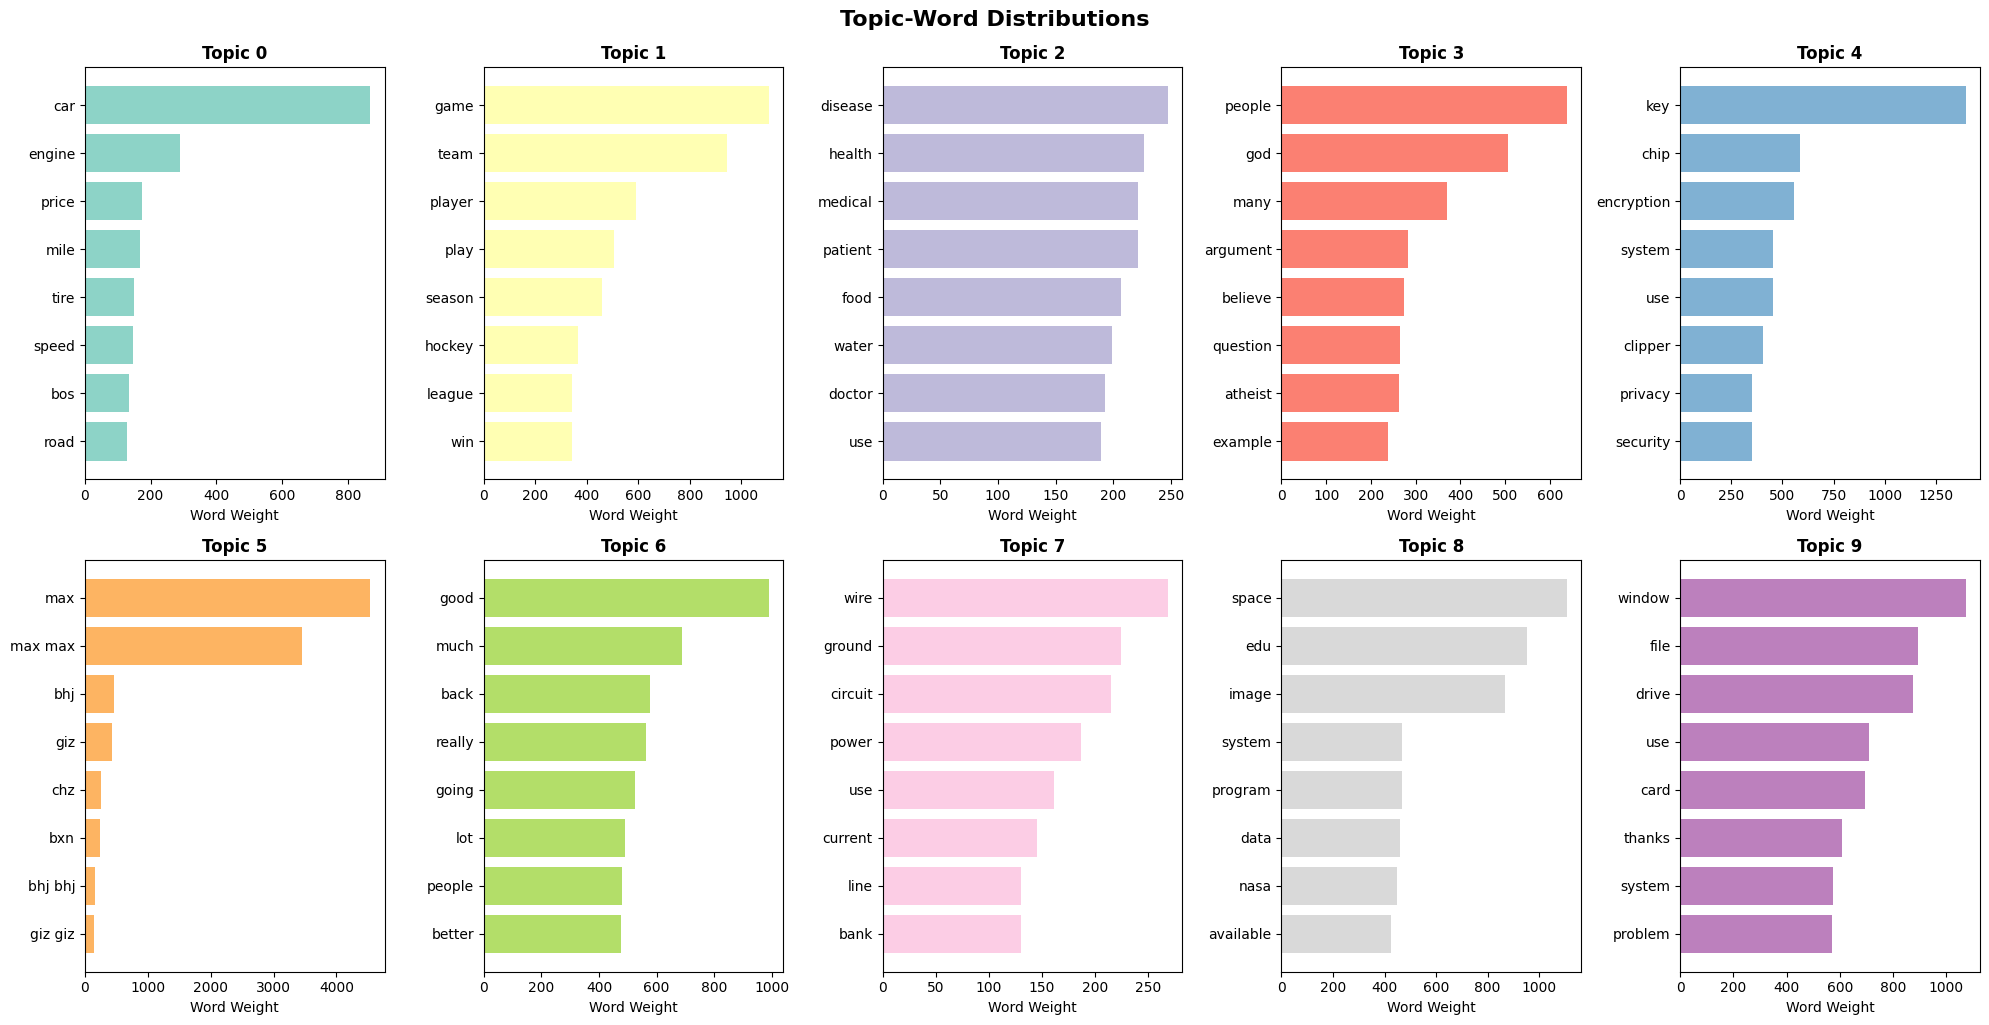

Topic similarity analysis:


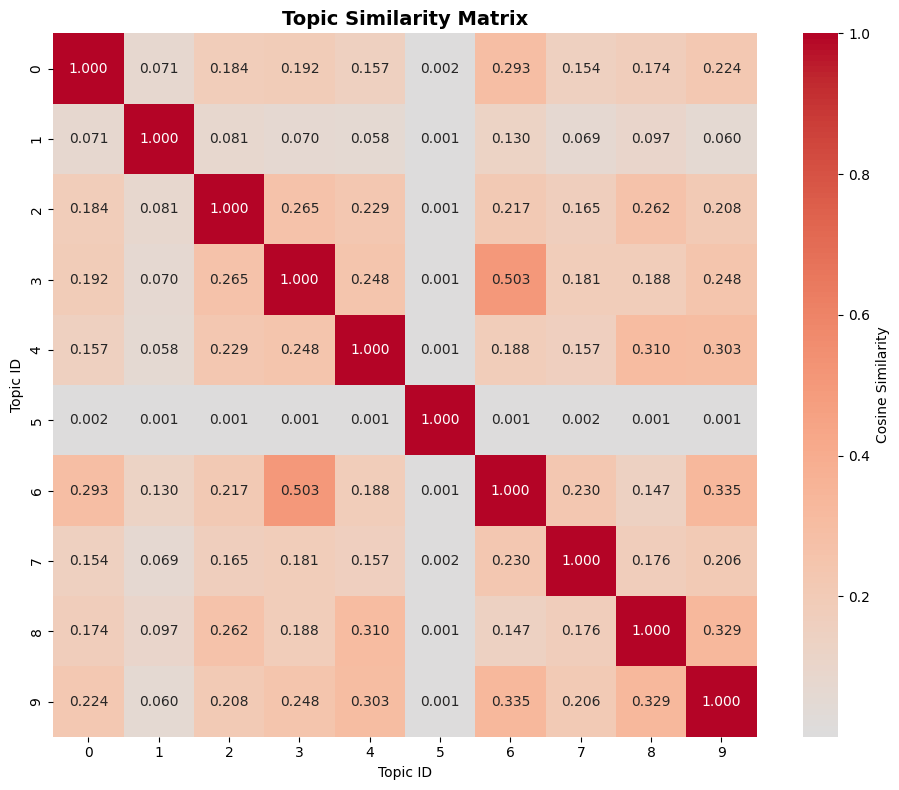

In [10]:
# Create comprehensive topic visualization
def plot_topic_word_distribution(model, feature_names, n_topics, n_words=8):
    """Create bar plots showing word distributions for each topic"""
    
    fig, axes = plt.subplots(2, 5, figsize=(20, 10))
    axes = axes.ravel()
    
    for topic_idx in range(n_topics):
        # Get top words for this topic
        top_words_idx = model.components_[topic_idx].argsort()[-n_words:][::-1]
        top_words = [feature_names[i] for i in top_words_idx]
        top_weights = [model.components_[topic_idx][i] for i in top_words_idx]
        
        # Create bar plot
        axes[topic_idx].barh(range(n_words), top_weights, color=plt.cm.Set3(topic_idx))
        axes[topic_idx].set_yticks(range(n_words))
        axes[topic_idx].set_yticklabels(top_words)
        axes[topic_idx].set_title(f'Topic {topic_idx}', fontweight='bold')
        axes[topic_idx].set_xlabel('Word Weight')
        
        # Invert y-axis to show highest weight at top
        axes[topic_idx].invert_yaxis()
    
    plt.tight_layout()
    plt.suptitle('Topic-Word Distributions', fontsize=16, fontweight='bold', y=1.02)
    plt.show()

# Create the visualization
plot_topic_word_distribution(lda_model, feature_names, n_topics)

# Create topic similarity heatmap
def plot_topic_similarity_heatmap(model):
    """Create heatmap showing similarity between topics"""
    
    # Calculate cosine similarity between topic vectors
    from sklearn.metrics.pairwise import cosine_similarity
    
    topic_similarity = cosine_similarity(model.components_)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(topic_similarity, 
                annot=True, 
                cmap='coolwarm', 
                center=0,
                square=True,
                fmt='.3f',
                cbar_kws={'label': 'Cosine Similarity'})
    
    plt.title('Topic Similarity Matrix', fontsize=14, fontweight='bold')
    plt.xlabel('Topic ID')
    plt.ylabel('Topic ID')
    plt.tight_layout()
    plt.show()

print("Topic similarity analysis:")
plot_topic_similarity_heatmap(lda_model)


#### Assign Dominant Topics to Documents

In [11]:
# Transform documents to get topic distributions
print("Assigning dominant topics to documents...")

# Get document-topic probability matrix
doc_topic_probs = lda_model.transform(doc_term_matrix)

def assign_dominant_topics(doc_topic_probs, feature_names, lda_model, original_texts):
    """
    For each document, find the topic with the highest probability
    and return detailed information about topic assignments
    """
    topic_assignments = []
    
    for doc_idx, topic_probs in enumerate(doc_topic_probs):
        # Find dominant topic (highest probability)
        dominant_topic_idx = np.argmax(topic_probs)
        dominant_topic_prob = topic_probs[dominant_topic_idx]
        
        # Get top words for the dominant topic
        topic_words_idx = lda_model.components_[dominant_topic_idx].argsort()[-5:][::-1]
        topic_keywords = [feature_names[i] for i in topic_words_idx]
        
        topic_assignments.append({
            'Document_ID': doc_idx,
                'Dominant_Topic': dominant_topic_idx,
            'Topic_Probability': round(dominant_topic_prob, 4),
            'Topic_Keywords': ', '.join(topic_keywords),
            'Original_Text': original_texts[doc_idx][:200] + '...'
        })
    
    return pd.DataFrame(topic_assignments)

# Assign dominant topics
topic_assignments_df = assign_dominant_topics(
    doc_topic_probs, 
    feature_names, 
    lda_model, 
    df['text'].tolist()
)

print(f"Topic assignments completed for {len(topic_assignments_df)} documents")
print("\nSample topic assignments:")
print(topic_assignments_df[['Document_ID', 'Dominant_Topic', 'Topic_Probability', 'Topic_Keywords']].head(10))

# Add topic assignments to original dataframe
df['dominant_topic'] = topic_assignments_df['Dominant_Topic']
df['topic_probability'] = topic_assignments_df['Topic_Probability']

# Show average topic probability (confidence measure)
avg_confidence = df['topic_probability'].mean()
print(f"\nAverage topic assignment confidence: {avg_confidence:.3f}")


Assigning dominant topics to documents...
Topic assignments completed for 6215 documents

Sample topic assignments:
   Document_ID  Dominant_Topic  Topic_Probability  \
0            0               6             0.4637   
1            1               6             0.5354   
2            2               9             0.8636   
3            3               0             0.7520   
4            4               9             0.9769   
5            5               5             0.9995   
6            6               3             0.5042   
7            7               9             0.6695   
8            8               1             0.6832   
9            9               9             0.9087   

                         Topic_Keywords  
0       good, much, back, really, going  
1       good, much, back, really, going  
2        window, file, drive, use, card  
3        car, engine, price, mile, tire  
4        window, file, drive, use, card  
5           max, max max, bhj, giz, chz  
6  peo

#### Topic Distribution Analysis

Topic Distribution Analysis:
Topic 0: 467 docs (7.5%)
Keywords: car, engine, price, mile, tire, speed, bos, road
--------------------------------------------------
Topic 1: 492 docs (7.9%)
Keywords: game, team, player, play, season, hockey, league, win
--------------------------------------------------
Topic 2: 237 docs (3.8%)
Keywords: disease, health, medical, patient, food, water, doctor, use
--------------------------------------------------
Topic 3: 596 docs (9.6%)
Keywords: people, god, many, argument, believe, question, atheist, example
--------------------------------------------------
Topic 4: 450 docs (7.2%)
Keywords: key, chip, encryption, system, use, clipper, privacy, security
--------------------------------------------------
Topic 5: 22 docs (0.4%)
Keywords: max, max max, bhj, giz, chz, bxn, bhj bhj, giz giz
--------------------------------------------------
Topic 6: 1728 docs (27.8%)
Keywords: good, much, back, really, going, lot, people, better
------------------------

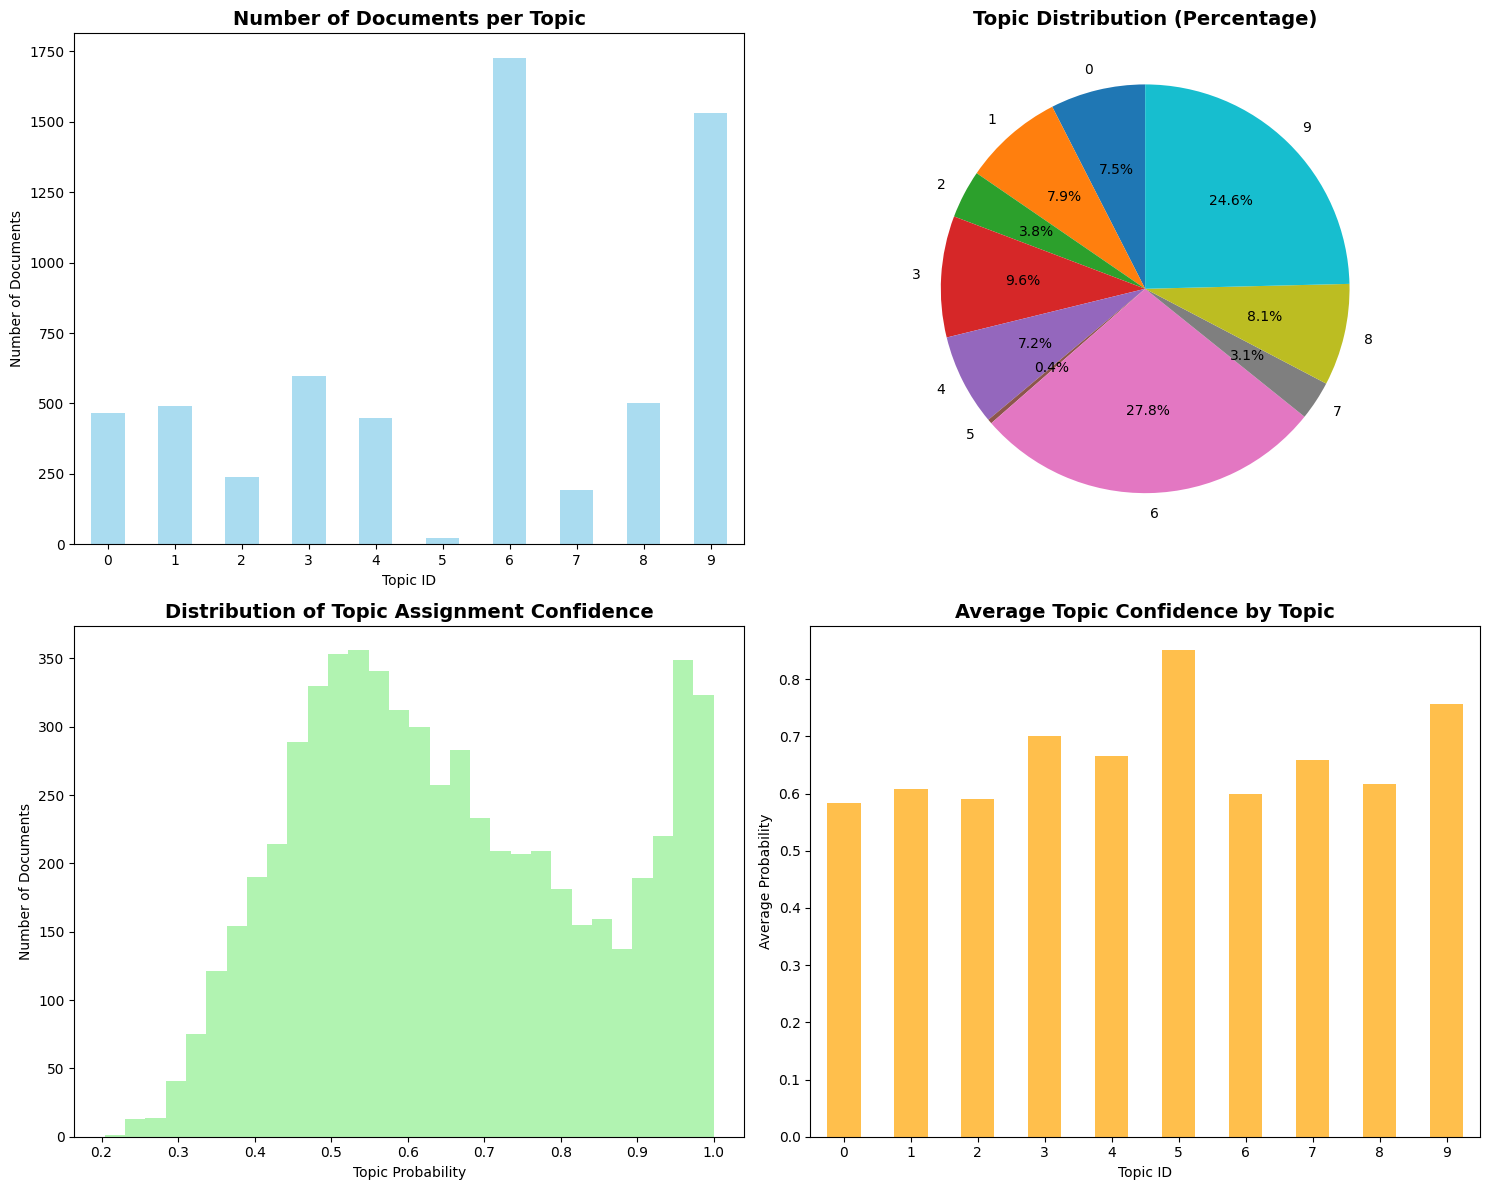


Detailed Topic Summary:
Topic 0: 467 docs (7.5%)
  Keywords: car(868.733), engine(288.977), price(174.982), mile(168.495), tire(148.242), speed(148.047), bos(134.940), road(128.270)

Topic 1: 492 docs (7.9%)
  Keywords: game(1108.620), team(945.151), player(592.004), play(505.215), season(460.565), hockey(366.223), league(344.100), win(343.189)

Topic 2: 237 docs (3.8%)
  Keywords: disease(247.368), health(226.671), medical(221.218), patient(221.160), food(206.378), water(199.211), doctor(192.945), use(189.387)

Topic 3: 596 docs (9.6%)
  Keywords: people(637.947), god(506.034), many(369.810), argument(283.854), believe(274.313), question(264.629), atheist(263.100), example(238.989)

Topic 4: 450 docs (7.2%)
  Keywords: key(1396.937), chip(587.251), encryption(558.100), system(452.056), use(451.647), clipper(402.857), privacy(351.100), security(349.379)

Topic 5: 22 docs (0.4%)
  Keywords: max(4539.100), max max(3457.100), bhj(456.100), giz(433.100), chz(257.100), bxn(240.100), bhj bh

In [12]:
# Analyze topic distribution across the corpus
topic_counts = df['dominant_topic'].value_counts().sort_index()

print("Topic Distribution Analysis:")
print("=" * 50)

# Create comprehensive topic summary
topic_summary = []
for topic_id in range(n_topics):
    # Get top words for this topic
    top_words_idx = lda_model.components_[topic_id].argsort()[-8:][::-1]
    top_words = [feature_names[i] for i in top_words_idx]
    word_weights = [lda_model.components_[topic_id][i] for i in top_words_idx]
    
    # Format words with weights
    words_with_weights = [f"{word}({weight:.3f})" for word, weight in zip(top_words, word_weights)]
    
    # Count documents assigned to this topic
    doc_count = topic_counts.get(topic_id, 0)
    percentage = (doc_count / len(df)) * 100
    
    topic_summary.append({
        'Topic_ID': topic_id,
        'Document_Count': doc_count,
        'Percentage': f"{percentage:.1f}%",
        'Top_Words': ', '.join(words_with_weights)
    })
    
    print(f"Topic {topic_id}: {doc_count} docs ({percentage:.1f}%)")
    print(f"Keywords: {', '.join(top_words)}")
    print("-" * 50)

# Create visualization of topic distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Bar plot of document counts per topic
topic_counts.plot(kind='bar', ax=axes[0,0], color='skyblue', alpha=0.7)
axes[0,0].set_title('Number of Documents per Topic', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Topic ID')
axes[0,0].set_ylabel('Number of Documents')
axes[0,0].tick_params(axis='x', rotation=0)

# Pie chart of topic distribution
topic_counts.plot(kind='pie', ax=axes[0,1], autopct='%1.1f%%', startangle=90)
axes[0,1].set_title('Topic Distribution (Percentage)', fontsize=14, fontweight='bold')
axes[0,1].set_ylabel('')

# Topic probability distribution
axes[1,0].hist(df['topic_probability'], bins=30, alpha=0.7, color='lightgreen')
axes[1,0].set_title('Distribution of Topic Assignment Confidence', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Topic Probability')
axes[1,0].set_ylabel('Number of Documents')

# Average topic probability by topic
topic_avg_probs = df.groupby('dominant_topic')['topic_probability'].mean()
topic_avg_probs.plot(kind='bar', ax=axes[1,1], color='orange', alpha=0.7)
axes[1,1].set_title('Average Topic Confidence by Topic', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Topic ID')
axes[1,1].set_ylabel('Average Probability')
axes[1,1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

# Display topic summary table
topic_summary_df = pd.DataFrame(topic_summary)
print("\nDetailed Topic Summary:")
for _, row in topic_summary_df.iterrows():
    print(f"Topic {row['Topic_ID']}: {row['Document_Count']} docs ({row['Percentage']})")
    print(f"  Keywords: {row['Top_Words']}")
    print()


# Conclusion

## Summary
This notebook demonstrated topic modeling using scikit-learn's LDA:
1. **Preprocessing**: Cleaned and vectorized 20 Newsgroups dataset
2. **Modeling**: Trained LDA to discover 10 topics from text data
3. **Analysis**: Visualized topics and assigned documents to dominant themes

## Key Results
- Successfully identified distinct topics in newsgroup discussions
- Perplexity analysis helped determine optimal number of topics
- Topic assignments provide interpretable document categorization

## Applications
- **Content Analysis**: Understand themes in large document collections
- **Document Clustering**: Group similar texts automatically
- **Information Retrieval**: Topic-based search and recommendations


This framework provides a scalable approach to discovering hidden patterns in unstructured text data.
